# Import Model

In [1]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.act1  = nn.SiLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        self.act2 = nn.SiLU()

    def forward(self, x):
        identity = x
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        if self.shortcut is not None:
            identity = self.shortcut(x)
        return out + identity



class DeepTileEncoder(nn.Module):
    """加深的 Tile 分支：全局信息，多尺度池化 + 三层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 78→39
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 39→19
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128),
            nn.MaxPool2d(2)  # 19→9
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256),
            ResidualBlock(256, 256)
        )  # 保持 9×9

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # [B,256,1,1]
        self.mid_pool    = nn.AdaptiveAvgPool2d((3, 3))  # [B,256,3,3]

        total_dim = 256*1*1 + 256*3*3
        # 三层 MLP：total_dim → 2*out_dim → out_dim → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*4),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*4, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # x: [B,256,9,9]
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)  # [B,256]
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)     # [B,256*3*3]

        return self.fc(torch.cat([g, m], dim=1))


class SubtileEncoder(nn.Module):
    """多尺度 Subtile 分支：局部信息 + 两层 MLP"""
    def __init__(self, out_dim, in_channels=3, negative_slope=0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 保持 6×6

        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        # 两层 MLP：total_dim → out_dim*2 → out_dim
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        B, N, C, H, W = x.shape
        x = x.contiguous().reshape(B*N, C, H, W)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        # g,m: [B*N, feat]
        g = self.global_pool(x).contiguous().reshape(B, N, -1)
        m = self.mid_pool(x).contiguous().reshape(B, N, -1)
        l = self.large_pool(x).contiguous().reshape(B, N, -1)

        # 合并 N 张 subtiles，再 FC
        feat = torch.cat([g, m, l], dim=2).mean(dim=1).contiguous()  # [B, total_dim]
        return self.fc(feat)
class CenterSubtileEncoder(nn.Module):
    """專門處理中心 subtile 的 Encoder"""
    def __init__(self, out_dim, in_channels=3, negative_slope= 0.01):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.SiLU(),
            nn.MaxPool2d(2)  # 26→13
        )
        self.layer1 = nn.Sequential(
            ResidualBlock(32, 64),
            ResidualBlock(64, 64),
            nn.MaxPool2d(2)  # 13→6
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128),
            ResidualBlock(128, 128)
        )  # 6×6

        # 多尺度池化
        self.global_pool = nn.AdaptiveAvgPool2d((1,1))
        self.mid_pool    = nn.AdaptiveAvgPool2d((2,2))
        self.large_pool    = nn.AdaptiveAvgPool2d((3,3))

        total_dim = 128*1*1 + 128*2*2 + 128*3*3
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.1),
            nn.Linear(total_dim, out_dim*2),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(out_dim*2, out_dim),
            nn.LeakyReLU(negative_slope),
        )

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        g = self.global_pool(x).contiguous().reshape(x.size(0), -1)
        m = self.mid_pool(x).contiguous().reshape(x.size(0), -1)
        l = self.large_pool(x).contiguous().reshape(x.size(0), -1)

        return self.fc(torch.cat([g, m, l], dim=1)).contiguous()



class VisionMLP_MultiTask(nn.Module):
    """整體多任務模型：融合 tile + subtile + center，使用動態權重融合"""
    def __init__(self, tile_dim=128, subtile_dim=64, output_dim=35, negative_slope=0.01):
        super().__init__()
        self.encoder_tile    = DeepTileEncoder(tile_dim)
        self.encoder_subtile = SubtileEncoder(subtile_dim)
        self.encoder_center  = CenterSubtileEncoder(subtile_dim)

        # 輸出 decoder：輸入為 tile_dim (因為融合後只剩一個 vector)
        self.decoder = nn.Sequential(
            nn.Linear(tile_dim + subtile_dim + subtile_dim , 256),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.LeakyReLU(negative_slope),
            nn.Dropout(0.1),
            nn.Linear(64, output_dim),
        )

    def forward(self, tile, subtiles):
        tile = tile.contiguous()
        subtiles = subtiles.contiguous()
        center = subtiles[:, 4]

        f_tile = self.encoder_tile(tile)         # [B, tile_dim]
        f_sub  = self.encoder_subtile(subtiles)  # [B, subtile_dim]
        f_center = self.encoder_center(center)   # [B, subtile_dim]

        # 拼接三個分支做 gating
        features_cat = torch.cat([f_tile, f_sub, f_center], dim=1)  # [B, tile+sub+center]
        return self.decoder(features_cat)





# 用法示例
model = VisionMLP_MultiTask(tile_dim=128, subtile_dim=128, output_dim=35)


# —— 5) 确保只有 decoder 可训练 ——  
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable / total params = {trainable:,} / {total:,}")
model


Trainable / total params = 6,679,843 / 6,679,843
Trainable / total params = 6,679,843 / 6,679,843


VisionMLP_MultiTask(
  (encoder_tile): DeepTileEncoder(
    (layer0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        

## Load Model

# Import training data

## Same in multiple .pt

In [2]:
import os
import torch
import random
import inspect
from python_scripts.import_data import load_all_tile_data

# 用法範例
#folder = "dataset/spot-rank/version-3/only_tile_sub/original_train"
folder = "dataset/spot-rank/filtered_directly_rank/masked/realign/Macenko_masked/filtered/train_data/"

grouped_data = load_all_tile_data( 
        folder_path=folder,
        model=model,
        fraction=1,
        shuffle=False
    )

    # grouped_data 現在只會有 model.forward() 需要的 key，
    # 像 ['tile','subtiles','neighbors','norm_coord','node_feat','adj_list','edge_feat','label','source_idx']
print("Loaded keys:", grouped_data.keys())
print("Samples:", len(next(iter(grouped_data.values()))))




/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:251: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_

Loaded keys: dict_keys(['tile', 'source_idx', 'label', 'position', 'slide_idx', 'subtiles'])
Samples: 8348


In [3]:
from python_scripts.import_data import convert_item, get_model_inputs

import torch
from torch.utils.data import Dataset
import inspect
import numpy as np

class importDataset(Dataset):
    def __init__(self, data_dict, model, image_keys=None, transform=None, print_sig=False):
        self.data = data_dict
        self.image_keys = set(image_keys) if image_keys is not None else set()
        self.transform = transform if transform is not None else lambda x: x
        self.forward_keys = list(get_model_inputs(model, print_sig=print_sig).parameters.keys())

        expected_length = None
        for key, value in self.data.items():
            if expected_length is None:
                expected_length = len(value)
            if len(value) != expected_length:
                raise ValueError(f"資料欄位 '{key}' 的長度 ({len(value)}) 與預期 ({expected_length}) 不一致。")

        for key in self.forward_keys:
            if key not in self.data:
                raise ValueError(f"data_dict 缺少模型 forward 所需欄位: '{key}'。目前可用的欄位: {list(self.data.keys())}")
        if "label" not in self.data:
            raise ValueError(f"data_dict 必須包含 'label' 欄位。可用的欄位: {list(self.data.keys())}")
        if "source_idx" not in self.data:
            raise ValueError("data_dict 必須包含 'source_idx' 欄位，用於 trace 原始順序對應。")
        if "position" not in self.data:
            raise ValueError("data_dict 必須包含 'position' 欄位，用於 trace 原始順序對應。")
    def __len__(self):
        return len(next(iter(self.data.values())))

    def __getitem__(self, idx):
        sample = {}
        for key in self.forward_keys:
            value = self.data[key][idx]
            value = self.transform(value)
            value = convert_item(value, is_image=(key in self.image_keys))
            if isinstance(value, torch.Tensor):
                value = value.float()
            sample[key] = value

        label = self.transform(self.data["label"][idx])
        label = convert_item(label, is_image=False)
        if isinstance(label, torch.Tensor):
            label = label.float()
        sample["label"] = label

        # 加入 source_idx
        source_idx = self.data["source_idx"][idx]
        sample["source_idx"] = torch.tensor(source_idx, dtype=torch.long)
        # 加入 position （假设 data_dict 中 'position' 是 (x, y) 或 [x, y]）
        pos = self.data["position"][idx]
        sample["position"] = torch.tensor(pos, dtype=torch.float)
        return sample
    def check_item(self, idx=0, num_lines=5):
        expected_keys = self.forward_keys + ['label', 'source_idx', 'position']
        sample = self[idx]
        print(f"🔍 Checking dataset sample: {idx}")
        for key in expected_keys:
            if key not in sample:
                print(f"❌ 資料中缺少 key: {key}")
                continue
            tensor = sample[key]
            if isinstance(tensor, torch.Tensor):
                try:
                    shape = tensor.shape
                except Exception:
                    shape = "N/A"
                dtype = tensor.dtype if hasattr(tensor, "dtype") else "N/A"
                output_str = f"📏 {key} shape: {shape} | dtype: {dtype}"
                if tensor.numel() > 0:
                    try:
                        tensor_float = tensor.float()
                        mn = tensor_float.min().item()
                        mx = tensor_float.max().item()
                        mean = tensor_float.mean().item()
                        std = tensor_float.std().item()
                        output_str += f" | min: {mn:.3f}, max: {mx:.3f}, mean: {mean:.3f}, std: {std:.3f}"
                    except Exception:
                        output_str += " | 無法計算統計數據"
                print(output_str)
                if key not in self.image_keys:
                    if tensor.ndim == 0:
                        print(f"--- {key} 資料為純量:", tensor)
                    elif tensor.ndim == 1:
                        print(f"--- {key} head (前 {num_lines} 個元素):")
                        print(tensor[:num_lines])
                    else:
                        print(f"--- {key} head (前 {num_lines} 列):")
                        print(tensor[:num_lines])
            else:
                # 如果 position 存的是 list/tuple/etc，也会走这里
                print(f"📏 {key} (非 tensor 資料):", tensor)
        print("✅ All checks passed!")


full_dataset = importDataset(grouped_data, model,
                             image_keys=['tile','subtiles'],
                             transform=lambda x: x)

full_dataset.check_item()

🔍 Checking dataset sample: 0
📏 tile shape: torch.Size([3, 78, 78]) | dtype: torch.float32 | min: 0.157, max: 1.000, mean: 0.680, std: 0.142
📏 subtiles shape: torch.Size([9, 3, 26, 26]) | dtype: torch.float32 | min: 0.157, max: 1.000, mean: 0.680, std: 0.142
📏 label shape: torch.Size([35]) | dtype: torch.float32 | min: 1.000, max: 35.000, mean: 18.000, std: 10.247
--- label head (前 5 個元素):
tensor([12., 24., 18.,  6., 30.])
📏 source_idx shape: torch.Size([]) | dtype: torch.int64 | min: 0.000, max: 0.000, mean: 0.000, std: nan
--- source_idx 資料為純量: tensor(0)
📏 position shape: torch.Size([2]) | dtype: torch.float32 | min: 0.171, max: 0.632, mean: 0.401, std: 0.326
--- position head (前 5 個元素):
tensor([0.6318, 0.1707])
✅ All checks passed!


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_3581/3062057575.py:79: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1744320376245/work/aten/src/ATen/native/ReduceOps.cpp:1823.)
  std = tensor_float.std().item()


In [ ]:

from python_scripts.image_features import  *
from python_scripts.prediction_features import  *
import numpy as np
from torch.utils.data import DataLoader

# === Main Function with Names ===
def generate_meta_features(dataset, model_for_recon, device, ae_type, oof_preds = None, latents = None):
    """
    Generate meta-features and corresponding names.

    Returns
    -------
    features : np.ndarray, shape (n_samples, n_features)
    names    : list of str, length n_features
    """

    # loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # 1) 收集所有 (feats, names) 到同一个 outputs 列表
    outputs = []

    # # # AE reconstruction loss
    # feats, names = compute_ae_reconstruction_loss(model_for_recon, loader, device, ae_type)
    # feats = feats[:, None]
    # outputs.append((feats, names))

    # # # # AE embeddings
    # # feats, names = compute_ae_embeddings(loader, model_for_recon, device)
    # # outputs.append((feats, names))
    # if latents is not None:
    #     # 原始 35 维 preds
    #     n_classes = latents.shape[1]
    #     raw_names = [f"trained-latents_{i}" for i in range(n_classes)]
    #     outputs.append((latents, raw_names))
    # # # # Latent stats
    # # # latent_feats = outputs[1][0]
    # # # feats, names = compute_latent_stats(latent_feats)
    # # # outputs.append((feats, names))

    # # # # RGB stats

    # feats, names = compute_center_subtile_rgb_stats(dataset)
    # outputs.append((feats, names))
    # feats, names = compute_subtiles_except_center_rgb_stats(dataset)
    # outputs.append((feats, names))
    # feats, names = compute_tile_rgb_stats(dataset)
    # outputs.append((feats, names))
    # feats, names = compute_subtile_contrast_stats(dataset)
    # outputs.append((feats, names))

    # # # # Texture & pattern features
    # feats, names = compute_wavelet_stats(dataset)
    # outputs.append((feats, names))
    # feats, names = compute_sobel_stats(dataset)
    # outputs.append((feats, names))

    # # Color & distribution features
    # feats, names = compute_hsv_stats(dataset)
    # outputs.append((feats, names))
    # # feats, names = compute_color_moments(dataset)
    # # outputs.append((feats, names))

    # # H&E stain features
    # feats, names = compute_he_stats(dataset)
    # outputs.append((feats, names))

    # # # # Sliding-window std stats
    # # # feats, names = compute_sliding_window_stats(dataset)
    # # # outputs.append((feats, names))

    # # 9) OOF-based features (only if provided)
    if oof_preds is not None:
        # 原始 35 维 preds
        n_classes = oof_preds.shape[1]
        raw_names = [f"oof_pred_{i}" for i in range(n_classes)]
        outputs.append((oof_preds, raw_names))

        # # 相邻差异
        feats, names = compute_adjacent_diffs(oof_preds, stride=1)
        outputs.append((feats, names))

        # # top-2..top-6 统计
        feats, names = compute_lastn_stats_multi(oof_preds, max_n=35)
        outputs.append((feats, names))
        # # feats, names = compute_topn_stats_multi(oof_preds, max_n=6)
        # # outputs.append((feats, names))
        # # 更多可选——只需取消注释即可
        # feats, names = compute_adj_diff_histogram(oof_preds)
        # outputs.append((feats, names))
        # feats, names = compute_multi_stride_diffs(oof_preds)
        # outputs.append((feats, names))
        feats, names = compute_median_mad(oof_preds)
        outputs.append((feats, names))
        feats, names = compute_skew_kurt(oof_preds)
        outputs.append((feats, names))
        # # feats, names = compute_percentile_iqr(oof_preds)
        # # outputs.append((feats, names))
        # # feats, names = compute_renyi_entropy(oof_preds, alpha=2)
        # # outputs.append((feats, names))
        # # feats, names = compute_js_uniform(oof_preds)
        # # outputs.append((feats, names))
        # # feats, names = compute_mass_topk(oof_preds, k=5)
        # # outputs.append((feats, names))
        # # feats, names = compute_cdf_slope(oof_preds)
        # # outputs.append((feats, names))
        # feats, names = compute_pca_components(oof_preds, n_components=10)
        # outputs.append((feats, names))
        # # feats, names = compute_log_stats(oof_preds)
        # # outputs.append((feats, names))
        # # feats, names = compute_peak_stats(oof_preds)
        # # outputs.append((feats, names))
        # # feats, names = compute_segment_stats(oof_preds)
        # # outputs.append((feats, names))
        # feats, names = compute_ar_coeffs(oof_preds)
        # outputs.append((feats, names))
        feats, names = compute_autocorr_features(oof_preds)
        outputs.append((feats, names))
        feats, names = compute_second_order_diffs(oof_preds)
        outputs.append((feats, names))
        feats, names = compute_third_order_diffs(oof_preds)
        outputs.append((feats, names))
        # feats, names = compute_log_adjacent_diffs(oof_preds)
        # outputs.append((feats, names))
        # feats, names = compute_relative_diffs(oof_preds)
        # outputs.append((feats, names))
        # feats, names = compute_diff_ratio_of_diffs(oof_preds)
        # outputs.append((feats, names))


    # 2) unzip 成 feat_list 和 name_seq
    feat_list, name_seq = zip(*outputs)

    # 3) 逐块校验 feats 列数与 names 长度
    for feats, names_block in zip(feat_list, name_seq):
        ncols = feats.shape[1] if feats.ndim == 2 else 1
        if ncols != len(names_block):
            raise ValueError(
                f"Mismatch: got {ncols} columns but {len(names_block)} names "
                f"in block '{names_block[0].split('_')[0]}'"
            )
        print(
            f"{names_block[0].split('_')[0]:12s} -> cols: {ncols:4d}, names: {len(names_block):4d} OK"
        )

    # 4) 扁平化 names 并拼接 features
    name_list = [nm for block in name_seq for nm in block]
    features = np.concatenate(feat_list, axis=1)
    print(f"✅ Generated meta-features with shape: {features.shape}")

    return features, name_list


In [74]:
from collections import defaultdict
import numpy as np

def diagnose_meta_nonfinite(meta: np.ndarray, names: list[str]):
    """
    按名字前缀分组，统计每组：
      - 原始特征数（列数）
      - 总值数（列数 × 行数）
      - NaN 值数量
      - ±Inf 值数量
      - 非数值（non-finite）总数

    Parameters
    ----------
    meta  : np.ndarray, shape (n_samples, n_features)
    names : list of str, length n_features

    Returns
    -------
    stats : dict[prefix, dict]  
        每个 prefix 对应一个字典，
        包含 'n_feats','total_vals','n_nan','n_inf','n_nonfinite'。
    """
    groups = defaultdict(list)
    # 按前缀分组
    for idx, nm in enumerate(names):
        prefix = nm.split('_', 1)[0]
        groups[prefix].append(idx)

    stats = {}
    for prefix, idxs in groups.items():
        sub = meta[:, idxs]  # shape (n_samples, n_group_feats)
        n_feats = sub.shape[1]
        total_vals = sub.size
        n_nan = np.isnan(sub).sum()
        n_inf = np.isinf(sub).sum()
        n_nonfinite = (~np.isfinite(sub)).sum()

        stats[prefix] = {
            'n_feats':        n_feats,
            'total_vals':     total_vals,
            'n_nan':          int(n_nan),
            'n_inf':          int(n_inf),
            'n_nonfinite':    int(n_nonfinite),
        }
        print(
            f"Group '{prefix}': "
            f"features={n_feats}, "
            f"values={total_vals}, "
            f"non-finite={n_nonfinite} "
            f"(nan={n_nan}, inf={n_inf})"
        )
    return stats


In [ ]:
from collections import defaultdict
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from collections import defaultdict
import numpy as np
from sklearn.decomposition import PCA

def groupwise_reduce(
    features: np.ndarray,
    names: list[str],   
    pca_ratio: float = 0.2
):
    """
    对每个类别组做 PCA 降维：
      - 对组内所有特征直接做 PCA，保留 pca_ratio 比例的主成分（至少1维）
      - 若 pca_ratio * m >= m，则保留全部原始特征
    返回拼接后的特征矩阵和对应名称
    """
    # 1) 按名字前缀分组
    groups = defaultdict(list)
    for idx, nm in enumerate(names):
        prefix = nm.split('_', 1)[0]
        groups[prefix].append(idx)

    all_feats = []
    all_names = []

    # 2) 对每个组直接做 PCA
    for prefix, idxs in groups.items():
        Xg = features[:, idxs]
        # 清洗非有限值
        Xg = np.nan_to_num(Xg, nan=0.0, posinf=0.0, neginf=0.0)

        m = Xg.shape[1]
        if m == 0:
            continue

        # 保留主成分数 k
        k = max(1, int(np.floor(m * pca_ratio)))

        if k >= m:
            # 保留原始特征
            Xg_p = Xg
            names_p = [names[i] for i in idxs]
        else:
            # PCA 降维到 k
            pca = PCA(n_components=k, random_state=0)
            Xg_p = pca.fit_transform(Xg)
            names_p = [f"{prefix}_pca{i}" for i in range(k)]

        print(f"Group '{prefix}': original {m} dims, PCA-> {Xg_p.shape[1]}")
        all_feats.append(Xg_p)
        all_names += names_p

    # 3) 拼接结果
    if not all_feats:
        raise RuntimeError("所有组降维失败，请检查输入。")
    reduced_feats = np.hstack(all_feats)
    print(f"总降维后维度：{reduced_feats.shape[1]}")
    return reduced_feats, all_names




meta, name = groupwise_reduce(
        features=meta_intial,
        names=name_intial,
    )

Group 'ae-recon-loss': original 1 dims, PCA-> 1
Group 'ae': original 384 dims, PCA-> 76
Group 'subtile4': original 12 dims, PCA-> 2
Group 'exsubtiles': original 12 dims, PCA-> 2
Group 'tile': original 12 dims, PCA-> 2
Group 'contrast': original 3 dims, PCA-> 1
Group 'wavelet-tile': original 4 dims, PCA-> 1
Group 'wavelet': original 240 dims, PCA-> 48
Group 'wavelet-subtile': original 36 dims, PCA-> 7
Group 'sobel-tile': original 4 dims, PCA-> 1
Group 'sobel-subtile': original 36 dims, PCA-> 7
Group 'hsv-tile': original 12 dims, PCA-> 2
Group 'hsv-subtile': original 108 dims, PCA-> 21
Group 'color-tile': original 12 dims, PCA-> 2
Group 'color-subtile': original 108 dims, PCA-> 21
Group 'he-tile': original 8 dims, PCA-> 1
Group 'he-subtile': original 72 dims, PCA-> 14
Group 'oof': original 35 dims, PCA-> 7
Group 'adj': original 34 dims, PCA-> 6
Group 'adj-his': original 10 dims, PCA-> 2
Group 'diff': original 595 dims, PCA-> 119
Group 'value': original 783 dims, PCA-> 156
Group 'mad': or

In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
from python_scripts.pretrain_model import PretrainedEncoderRegressor
# ---------------- Settings ----------------
trained_oof_model_folder = 'output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/'
n_folds    = len([d for d in os.listdir(trained_oof_model_folder) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35
BATCH_SIZE = 64
start_fold = 0

tile_dim = 128
center_dim = 128
neighbor_dim = 128
fusion_dim = tile_dim + center_dim + neighbor_dim

pretrained_ae_name = 'AE_Center_noaug'
pretrained_ae_path = f"AE_model/128/{pretrained_ae_name}/best.pt"
ae_type = 'center'

# Ground truth label (全 dataset)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.01,
    n_estimators=20000,
    max_depth=15,
    num_leaves=127,
    colsample_bytree=0.7619407413363416,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=20,
    reg_alpha=0.7480401395491829,
    reg_lambda=0.2589860348178542,
    verbosity=-1
    )


slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)


for fold_id, (tr_idx, va_idx) in enumerate(
    logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue

    print(f"\n🚀 Starting fold {fold_id}...")
    ckpt_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")

    # === Load model and predict OOF ===
    net = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net = net.to(device).eval()

    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds, latents = [], []
    with torch.no_grad():
        for batch in val_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            center = subtiles[:, 4].contiguous()

            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())

    preds = torch.cat(preds, dim=0).numpy()
    latents = torch.cat(latents, dim=0).numpy()

    # === AE model reconstruction loss ===
    recon_model = PretrainedEncoderRegressor(
        ae_checkpoint=pretrained_ae_path,
        ae_type=ae_type,
        tile_dim=tile_dim,
        center_dim=center_dim,
        neighbor_dim=neighbor_dim,
        output_dim=C,
        mode='reconstruction'
    ).to(device)

    meta, name = generate_meta_features(
        dataset = val_ds,
        oof_preds = preds,
        model_for_recon = recon_model,
        latents = latents,
        device = device,
        ae_type = ae_type,
    )
    stats = diagnose_meta_nonfinite(meta, name)

    
    y_val      = y_true[va_idx]           # (n_val, 35)
    resid_val  = y_val - preds            # (n_val, 35)
    # 2) 再對這個 fold 的 meta 做 train/val 切分
    X_train_tab, X_val_tab, y_train_tab, y_val_tab = train_test_split(
        meta, resid_val, test_size=0.2, random_state=42
    )

    # 3) train MultiOutputRegressor with early stopping
    meta_model = MultiOutputRegressor(lgb_base)
    meta_model.estimators_ = []

    for i in range(y_train_tab.shape[1]):
        cell_num = i +1
        print(f"[fold {fold_id}] training target {cell_num} on meta features …")
        model = lgb.LGBMRegressor(**lgb_base.get_params())
        model.fit(
            X_train_tab, y_train_tab[:, i], # 这里 y_train_tab 是 residual
            eval_set=[(X_val_tab, y_val_tab[:, i])], 
            callbacks=[
                early_stopping(stopping_rounds=200),
                log_evaluation(period=100)
            ]
        )
        meta_model.estimators_.append(model)

    # 4) 存下這個 fold 的 meta model
    save_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}","meta_model.pkl")
    joblib.dump(meta_model, save_path)
    print(f"✅ Saved fold {fold_id} meta‐model → {save_path}")



🚀 Starting fold 0...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_3581/2556379003.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, map

ae-recon-loss -> cols:    1, names:    1 OK
ae           -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
oof          -> cols:   35, names:   35 OK
mad          -> cols:    1, names:    1 OK
✅ Generated meta-features with shape: (2197, 740)
Group 'ae-recon-loss': features=1, values=2197, non-finite=0 (nan=0, inf=0)
Group 'ae': features=384, values=843648, non-finite=0 (nan=0, inf=0)
Group 'subtile4': features=12, values=26364, non-finite=0 (nan=0, inf=0)
Group 'exsubtiles': features=12, values=26364, non-finite=0 (nan=0, inf=0)
Group 'tile': features=12, values=26364, non-finite=0 (nan=0, inf=0)
Group 'contrast': features=3, values=6591, non-finite=0 (nan=0, inf=0)
Group 'wavelet-tile': features=4, values=8788, non-finite=0 (nan=0, inf=0)
Group 'wavelet': features=240, values=527280, non-fini

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.4736
[200]	valid_0's rmse: 6.25645
[300]	valid_0's rmse: 6.20793
[400]	valid_0's rmse: 6.18453
[500]	valid_0's rmse: 6.18401
[600]	valid_0's rmse: 6.18296
[700]	valid_0's rmse: 6.18382
Early stopping, best iteration is:
[575]	valid_0's rmse: 6.18063
[fold 0] training target 2 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.91184
[200]	valid_0's rmse: 2.40775
[300]	valid_0's rmse: 2.29765
[400]	valid_0's rmse: 2.26951
[500]	valid_0's rmse: 2.26323
[600]	valid_0's rmse: 2.26157
[700]	valid_0's rmse: 2.26021
[800]	valid_0's rmse: 2.25999
[900]	valid_0's rmse: 2.25912
[1000]	valid_0's rmse: 2.25796
[1100]	valid_0's rmse: 2.25884
[1200]	valid_0's rmse: 2.25902
Early stopping, best iteration is:
[1003]	valid_0's rmse: 2.25789
[fold 0] training target 3 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.59983
[200]	valid_0's rmse: 4.41081
[300]	valid_0's rmse: 4.36725
[400]	valid_0's rmse: 4.3615
[500]	valid_0's rmse: 4.35981
[600]	valid_0's rmse: 4.35907
[700]	valid_0's rmse: 4.35697
[800]	valid_0's rmse: 4.35613
[900]	valid_0's rmse: 4.35808
Early stopping, best iteration is:
[731]	valid_0's rmse: 4.35534
[fold 0] training target 4 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.89677
[200]	valid_0's rmse: 6.83021
[300]	valid_0's rmse: 6.81388
[400]	valid_0's rmse: 6.80754
[500]	valid_0's rmse: 6.81243
[600]	valid_0's rmse: 6.81858
Early stopping, best iteration is:
[411]	valid_0's rmse: 6.8048
[fold 0] training target 5 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.78647
[200]	valid_0's rmse: 5.61799
[300]	valid_0's rmse: 5.37731
[400]	valid_0's rmse: 5.31466
[500]	valid_0's rmse: 5.29551
[600]	valid_0's rmse: 5.28805
[700]	valid_0's rmse: 5.28633
[800]	valid_0's rmse: 5.28116
[900]	valid_0's rmse: 5.28074
[1000]	valid_0's rmse: 5.28015
Early stopping, best iteration is:
[838]	valid_0's rmse: 5.2778
[fold 0] training target 6 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.49461
[200]	valid_0's rmse: 6.60013
[300]	valid_0's rmse: 6.33968
[400]	valid_0's rmse: 6.2551
[500]	valid_0's rmse: 6.22707
[600]	valid_0's rmse: 6.21246
[700]	valid_0's rmse: 6.20449
[800]	valid_0's rmse: 6.20246
[900]	valid_0's rmse: 6.20374
[1000]	valid_0's rmse: 6.2026
[1100]	valid_0's rmse: 6.20405
Early stopping, best iteration is:
[991]	valid_0's rmse: 6.20196
[fold 0] training target 7 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.4015
[200]	valid_0's rmse: 4.06187
[300]	valid_0's rmse: 4.01906
[400]	valid_0's rmse: 4.01504
[500]	valid_0's rmse: 4.01747
Early stopping, best iteration is:
[380]	valid_0's rmse: 4.01298
[fold 0] training target 8 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.38683
[200]	valid_0's rmse: 5.38883
[300]	valid_0's rmse: 5.40409
Early stopping, best iteration is:
[124]	valid_0's rmse: 5.38303
[fold 0] training target 9 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.14523
[200]	valid_0's rmse: 6.48218
[300]	valid_0's rmse: 6.33184
[400]	valid_0's rmse: 6.28579
[500]	valid_0's rmse: 6.26549
[600]	valid_0's rmse: 6.25396
[700]	valid_0's rmse: 6.25192
[800]	valid_0's rmse: 6.25051
[900]	valid_0's rmse: 6.24834
[1000]	valid_0's rmse: 6.24769
[1100]	valid_0's rmse: 6.2444
[1200]	valid_0's rmse: 6.24476
[1300]	valid_0's rmse: 6.24568
[1400]	valid_0's rmse: 6.24456
Early stopping, best iteration is:
[1234]	valid_0's rmse: 6.2438
[fold 0] training target 10 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 8.83237
[200]	valid_0's rmse: 8.23889
[300]	valid_0's rmse: 8.06068
[400]	valid_0's rmse: 7.99901
[500]	valid_0's rmse: 7.9679
[600]	valid_0's rmse: 7.95447
[700]	valid_0's rmse: 7.96057
Early stopping, best iteration is:
[597]	valid_0's rmse: 7.95351
[fold 0] training target 11 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 8.50684
[200]	valid_0's rmse: 8.19453
[300]	valid_0's rmse: 8.1009
[400]	valid_0's rmse: 8.06818
[500]	valid_0's rmse: 8.05204
[600]	valid_0's rmse: 8.05609
[700]	valid_0's rmse: 8.05598
Early stopping, best iteration is:
[502]	valid_0's rmse: 8.05113
[fold 0] training target 12 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.75498
[200]	valid_0's rmse: 4.37706
[300]	valid_0's rmse: 4.27482
[400]	valid_0's rmse: 4.24081
[500]	valid_0's rmse: 4.2264
[600]	valid_0's rmse: 4.22626
[700]	valid_0's rmse: 4.22578
Early stopping, best iteration is:
[581]	valid_0's rmse: 4.22423
[fold 0] training target 13 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.95287
[200]	valid_0's rmse: 5.93471
[300]	valid_0's rmse: 5.94731
[400]	valid_0's rmse: 5.94845
Early stopping, best iteration is:
[203]	valid_0's rmse: 5.93074
[fold 0] training target 14 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.75118
[200]	valid_0's rmse: 5.74793
[300]	valid_0's rmse: 5.7615
Early stopping, best iteration is:
[140]	valid_0's rmse: 5.73401
[fold 0] training target 15 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.35797
[200]	valid_0's rmse: 5.12561
[300]	valid_0's rmse: 5.06011
[400]	valid_0's rmse: 5.02929
[500]	valid_0's rmse: 5.00371
[600]	valid_0's rmse: 4.99811
[700]	valid_0's rmse: 4.99458
[800]	valid_0's rmse: 4.98762
[900]	valid_0's rmse: 4.98667
[1000]	valid_0's rmse: 4.98581
[1100]	valid_0's rmse: 4.98318
[1200]	valid_0's rmse: 4.98199
[1300]	valid_0's rmse: 4.98257
Early stopping, best iteration is:
[1172]	valid_0's rmse: 4.98161
[fold 0] training target 16 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.52792
[200]	valid_0's rmse: 2.45168
[300]	valid_0's rmse: 2.41873
[400]	valid_0's rmse: 2.40534
[500]	valid_0's rmse: 2.39342
[600]	valid_0's rmse: 2.38132
[700]	valid_0's rmse: 2.37582
[800]	valid_0's rmse: 2.37476
[900]	valid_0's rmse: 2.37257
[1000]	valid_0's rmse: 2.36883
[1100]	valid_0's rmse: 2.36819
[1200]	valid_0's rmse: 2.36771
[1300]	valid_0's rmse: 2.36815
[1400]	valid_0's rmse: 2.36809
Early stopping, best iteration is:
[1230]	valid_0's rmse: 2.36666
[fold 0] training target 17 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.51472
[200]	valid_0's rmse: 6.84857
[300]	valid_0's rmse: 6.71349
[400]	valid_0's rmse: 6.67037
[500]	valid_0's rmse: 6.65615
[600]	valid_0's rmse: 6.65345
[700]	valid_0's rmse: 6.64797
[800]	valid_0's rmse: 6.64747
[900]	valid_0's rmse: 6.64153
[1000]	valid_0's rmse: 6.63774
[1100]	valid_0's rmse: 6.63692
[1200]	valid_0's rmse: 6.63529
[1300]	valid_0's rmse: 6.63417
[1400]	valid_0's rmse: 6.63368
[1500]	valid_0's rmse: 6.63288
[1600]	valid_0's rmse: 6.63248
[1700]	valid_0's rmse: 6.6311
[1800]	valid_0's rmse: 6.63017
[1900]	valid_0's rmse: 6.62958
[2000]	valid_0's rmse: 6.62939
[2100]	valid_0's rmse: 6.62873
[2200]	valid_0's rmse: 6.62844
[2300]	valid_0's rmse: 6.62789
[2400]	valid_0's rmse: 6.62742
[2500]	valid_0's rmse: 6.62698
[2600]	valid_0's rmse: 6.62667
[2700]	valid_0's rmse: 6.62633
[2800]	valid_0's rmse: 6.62632
[2900]	valid_0's rmse: 6.62612
[3000]	valid_0's rmse: 6.62609
[3100]	valid_0's rmse: 6.62611
Early stopping, best iteration is:
[2986]	valid_0

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.82115
[200]	valid_0's rmse: 3.79702
[300]	valid_0's rmse: 3.7966
[400]	valid_0's rmse: 3.79533
[500]	valid_0's rmse: 3.79816
Early stopping, best iteration is:
[377]	valid_0's rmse: 3.79255
[fold 0] training target 19 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.94531
[200]	valid_0's rmse: 7.6549
[300]	valid_0's rmse: 7.59659
[400]	valid_0's rmse: 7.58404
[500]	valid_0's rmse: 7.57959
[600]	valid_0's rmse: 7.57902
[700]	valid_0's rmse: 7.57977
Early stopping, best iteration is:
[591]	valid_0's rmse: 7.57821
[fold 0] training target 20 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.37562
[200]	valid_0's rmse: 5.01843
[300]	valid_0's rmse: 4.93682
[400]	valid_0's rmse: 4.9168
[500]	valid_0's rmse: 4.90993
[600]	valid_0's rmse: 4.90421
[700]	valid_0's rmse: 4.90121
[800]	valid_0's rmse: 4.90025
[900]	valid_0's rmse: 4.90257
Early stopping, best iteration is:
[774]	valid_0's rmse: 4.89877
[fold 0] training target 21 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.18912
[200]	valid_0's rmse: 6.64397
[300]	valid_0's rmse: 6.52794
[400]	valid_0's rmse: 6.50115
[500]	valid_0's rmse: 6.50481
Early stopping, best iteration is:
[390]	valid_0's rmse: 6.49737
[fold 0] training target 22 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.96452
[200]	valid_0's rmse: 7.48544
[300]	valid_0's rmse: 7.36761
[400]	valid_0's rmse: 7.35108
[500]	valid_0's rmse: 7.33924
[600]	valid_0's rmse: 7.34188
[700]	valid_0's rmse: 7.34342
Early stopping, best iteration is:
[533]	valid_0's rmse: 7.33268
[fold 0] training target 23 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.45868
[200]	valid_0's rmse: 3.09553
[300]	valid_0's rmse: 3.04571
[400]	valid_0's rmse: 3.04036
[500]	valid_0's rmse: 3.0405
Early stopping, best iteration is:
[380]	valid_0's rmse: 3.03919
[fold 0] training target 24 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.73412
[200]	valid_0's rmse: 6.60743
[300]	valid_0's rmse: 6.56721
[400]	valid_0's rmse: 6.5639
[500]	valid_0's rmse: 6.55506
[600]	valid_0's rmse: 6.55391
[700]	valid_0's rmse: 6.54776
[800]	valid_0's rmse: 6.54397
[900]	valid_0's rmse: 6.54705
Early stopping, best iteration is:
[793]	valid_0's rmse: 6.54343
[fold 0] training target 25 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.69794
[200]	valid_0's rmse: 7.62567
[300]	valid_0's rmse: 7.62649
[400]	valid_0's rmse: 7.62428
Early stopping, best iteration is:
[217]	valid_0's rmse: 7.61639
[fold 0] training target 26 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.07128
[200]	valid_0's rmse: 6.96144
[300]	valid_0's rmse: 6.95264
[400]	valid_0's rmse: 6.9489
Early stopping, best iteration is:
[264]	valid_0's rmse: 6.94284
[fold 0] training target 27 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.56929
[200]	valid_0's rmse: 6.87766
[300]	valid_0's rmse: 6.68616
[400]	valid_0's rmse: 6.61933
[500]	valid_0's rmse: 6.60458
[600]	valid_0's rmse: 6.58419
[700]	valid_0's rmse: 6.57301
[800]	valid_0's rmse: 6.56875
[900]	valid_0's rmse: 6.5708
[1000]	valid_0's rmse: 6.56724
[1100]	valid_0's rmse: 6.56629
[1200]	valid_0's rmse: 6.56457
[1300]	valid_0's rmse: 6.56381
[1400]	valid_0's rmse: 6.56346
Early stopping, best iteration is:
[1244]	valid_0's rmse: 6.56277
[fold 0] training target 28 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.39288
[200]	valid_0's rmse: 6.02623
[300]	valid_0's rmse: 5.9809
[400]	valid_0's rmse: 5.9762
[500]	valid_0's rmse: 5.98159
Early stopping, best iteration is:
[355]	valid_0's rmse: 5.97081
[fold 0] training target 29 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.19677
[200]	valid_0's rmse: 6.9668
[300]	valid_0's rmse: 6.9012
[400]	valid_0's rmse: 6.87431
[500]	valid_0's rmse: 6.86847
[600]	valid_0's rmse: 6.86248
[700]	valid_0's rmse: 6.86296
Early stopping, best iteration is:
[557]	valid_0's rmse: 6.85991
[fold 0] training target 30 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.92629
[200]	valid_0's rmse: 4.87546
[300]	valid_0's rmse: 4.85179
[400]	valid_0's rmse: 4.84195
[500]	valid_0's rmse: 4.83977
[600]	valid_0's rmse: 4.8378
Early stopping, best iteration is:
[442]	valid_0's rmse: 4.83433
[fold 0] training target 31 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.77155
[200]	valid_0's rmse: 3.24512
[300]	valid_0's rmse: 3.17213
[400]	valid_0's rmse: 3.16963
[500]	valid_0's rmse: 3.16886
[600]	valid_0's rmse: 3.16558
[700]	valid_0's rmse: 3.1637
[800]	valid_0's rmse: 3.16368
[900]	valid_0's rmse: 3.1637
[1000]	valid_0's rmse: 3.16391
Early stopping, best iteration is:
[823]	valid_0's rmse: 3.16311
[fold 0] training target 32 on meta features …


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.78094
[200]	valid_0's rmse: 2.68952
[300]	valid_0's rmse: 2.68142
[400]	valid_0's rmse: 2.68159
[500]	valid_0's rmse: 2.68727
Early stopping, best iteration is:
[367]	valid_0's rmse: 2.68003
[fold 0] training target 33 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 7.71484
[200]	valid_0's rmse: 7.70002
[300]	valid_0's rmse: 7.7031
[400]	valid_0's rmse: 7.7131
Early stopping, best iteration is:
[226]	valid_0's rmse: 7.69337
[fold 0] training target 34 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 5.67512
[200]	valid_0's rmse: 5.62672
[300]	valid_0's rmse: 5.61594
[400]	valid_0's rmse: 5.61775
[500]	valid_0's rmse: 5.62329
Early stopping, best iteration is:
[346]	valid_0's rmse: 5.61175
[fold 0] training target 35 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 3.35667
[200]	valid_0's rmse: 3.27675
[300]	valid_0's rmse: 3.26652
[400]	valid_0's rmse: 3.26005
[500]	valid_0's rmse: 3.26023
[600]	valid_0's rmse: 3.26551
Early stopping, best iteration is:
[475]	valid_0's rmse: 3.25821
✅ Saved fold 0 meta‐model → output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/fold0/meta_model.pkl
⏭️ Skipping fold 1
⏭️ Skipping fold 2
⏭️ Skipping fold 3
⏭️ Skipping fold 4
⏭️ Skipping fold 5


In [125]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
from python_scripts.pretrain_model import PretrainedEncoderRegressor
# ---------------- Settings ----------------
trained_oof_model_folder = 'output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/'
n_folds    = len([d for d in os.listdir(trained_oof_model_folder) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35
BATCH_SIZE = 64
start_fold = 0

tile_dim = 128
center_dim = 128
neighbor_dim = 128
fusion_dim = tile_dim + center_dim + neighbor_dim

pretrained_ae_name = 'AE_Center_noaug'
pretrained_ae_path = f"AE_model/128/{pretrained_ae_name}/best.pt"
ae_type = 'center'

# Ground truth label (全 dataset)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.01,
    n_estimators=20000,
    max_depth=15,
    num_leaves=127,
    colsample_bytree=0.7619407413363416,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=20,
    reg_alpha=0.7480401395491829,
    reg_lambda=0.2589860348178542,
    verbosity=-1
    )


slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)

N, C = len(full_dataset), 35
oof_preds = np.zeros((N, C), dtype=float)
oof_latents = np.zeros((N, 128*3), dtype=float)

for fold_id, (tr_idx, va_idx) in enumerate(
    logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue

    print(f"\n🚀 Starting fold {fold_id}...")
    ckpt_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")

    # === Load model and predict OOF ===
    net = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net = net.to(device).eval()

    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds, latents = [], []
    with torch.no_grad():
        for batch in val_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            center = subtiles[:, 4].contiguous()

            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())


    preds = torch.cat(preds, dim=0).numpy()        # (n_val, C)
    oof_preds[va_idx] = preds                       # 按索引写回 numpy 数组
    latents = torch.cat(latents, dim=0).numpy()
    oof_latents[va_idx] = latents                       # 按索引写回 numpy 数组

# 2) 用完整的 oof_preds 一次生成所有 meta-features
recon = PretrainedEncoderRegressor(
    ae_checkpoint=pretrained_ae_path,
    ae_type=ae_type,
    tile_dim=tile_dim,
    center_dim=center_dim,
    neighbor_dim=neighbor_dim,
    output_dim=C,
    mode='reconstruction'
).to(device)

meta_all, meta_names = generate_meta_features(
    dataset=full_dataset,
    oof_preds=oof_preds,
    model_for_recon=recon,
    latents = oof_latents,
    device=device,
    ae_type=ae_type
)  # meta_all.shape == (N, D_meta)
diagnose_meta_nonfinite(meta_all, meta_names)
# 3) 构造 y_true，与 oof_preds 顺序一致
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(N) ])

from sklearn.preprocessing import StandardScaler

# 假设 X_meta 的 shape 是 (N, 35 + D_image)
scaler = StandardScaler()

# 之后就把 X_meta_scaled 丢给你的 meta-model

# 划 train/val
X_tr, X_val, y_tr, y_val = train_test_split(
    meta_all, y_true, test_size=0.2, random_state=42
)

scaler = StandardScaler().fit(X_tr)
X_tr_scaled  = scaler.transform(X_tr)
X_val_scaled = scaler.transform(X_val)


# 5) 训练 MultiOutputRegressor
meta_model = MultiOutputRegressor(lgb_base)
meta_model.estimators_ = []

for i in range(C):
    print(f"→ Training meta target {i}")
    m = lgb.LGBMRegressor(**lgb_base.get_params())
    m.fit(
        X_tr_scaled, y_tr[:, i],
        eval_set=[(X_val_scaled, y_val[:, i])],
        callbacks=[early_stopping(stopping_rounds=200), log_evaluation(period=100)]
    )
    meta_model.estimators_.append(m)

# 6) 保存一次训练好的 meta-model
joblib.dump(meta_model, os.path.join(trained_oof_model_folder, "meta_model.pkl"))
print("✅ Meta‐model saved.")


🚀 Starting fold 0...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_3581/3837923258.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, map


🚀 Starting fold 1...

🚀 Starting fold 2...

🚀 Starting fold 3...

🚀 Starting fold 4...

🚀 Starting fold 5...


/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/pretrain_model.py:310: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ae.load_state_dict(torch.load(ae_checkpoint, map_

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (8348, 1222)
→ Training meta target 0


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.50746
[200]	valid_0's rmse: 5.07442
[300]	valid_0's rmse: 5.005
[400]	valid_0's rmse: 4.98823
[500]	valid_0's rmse: 4.98602
[600]	valid_0's rmse: 4.98674
Early stopping, best iteration is:
[497]	valid_0's rmse: 4.98523
→ Training meta target 1


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.55075
[200]	valid_0's rmse: 2.31746
[300]	valid_0's rmse: 2.26258
[400]	valid_0's rmse: 2.24507
[500]	valid_0's rmse: 2.23736
[600]	valid_0's rmse: 2.23362
[700]	valid_0's rmse: 2.23128
[800]	valid_0's rmse: 2.22895
[900]	valid_0's rmse: 2.2275
[1000]	valid_0's rmse: 2.22718
[1100]	valid_0's rmse: 2.2263
[1200]	valid_0's rmse: 2.22598
[1300]	valid_0's rmse: 2.22539
[1400]	valid_0's rmse: 2.22502
[1500]	valid_0's rmse: 2.22507
[1600]	valid_0's rmse: 2.22478
[1700]	valid_0's rmse: 2.22475
[1800]	valid_0's rmse: 2.22458
[1900]	valid_0's rmse: 2.22461
[2000]	valid_0's rmse: 2.22459
[2100]	valid_0's rmse: 2.22462
Early stopping, best iteration is:
[1969]	valid_0's rmse: 2.22454
→ Training meta target 2


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.82044
[200]	valid_0's rmse: 3.39814
[300]	valid_0's rmse: 3.32805
[400]	valid_0's rmse: 3.31374
[500]	valid_0's rmse: 3.31101
[600]	valid_0's rmse: 3.30985
[700]	valid_0's rmse: 3.31031
Early stopping, best iteration is:
[530]	valid_0's rmse: 3.30863
→ Training meta target 3


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.60011
[200]	valid_0's rmse: 6.72922
[300]	valid_0's rmse: 6.58872
[400]	valid_0's rmse: 6.56233
[500]	valid_0's rmse: 6.55305
[600]	valid_0's rmse: 6.55016
[700]	valid_0's rmse: 6.54814
[800]	valid_0's rmse: 6.54735
[900]	valid_0's rmse: 6.54883
Early stopping, best iteration is:
[785]	valid_0's rmse: 6.54643
→ Training meta target 4


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.19158
[200]	valid_0's rmse: 6.40524
[300]	valid_0's rmse: 6.23925
[400]	valid_0's rmse: 6.19149
[500]	valid_0's rmse: 6.16662
[600]	valid_0's rmse: 6.14861
[700]	valid_0's rmse: 6.14156
[800]	valid_0's rmse: 6.13665
[900]	valid_0's rmse: 6.13086
[1000]	valid_0's rmse: 6.12728
[1100]	valid_0's rmse: 6.12491
[1200]	valid_0's rmse: 6.12331
[1300]	valid_0's rmse: 6.12269
[1400]	valid_0's rmse: 6.12035
[1500]	valid_0's rmse: 6.11893
[1600]	valid_0's rmse: 6.1187
[1700]	valid_0's rmse: 6.11818
[1800]	valid_0's rmse: 6.11764
[1900]	valid_0's rmse: 6.11705
[2000]	valid_0's rmse: 6.11665
[2100]	valid_0's rmse: 6.11659
[2200]	valid_0's rmse: 6.11649
[2300]	valid_0's rmse: 6.11623
[2400]	valid_0's rmse: 6.11615
[2500]	valid_0's rmse: 6.11623
Early stopping, best iteration is:
[2365]	valid_0's rmse: 6.116
→ Training meta target 5


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.90384
[200]	valid_0's rmse: 7.11565
[300]	valid_0's rmse: 6.90921
[400]	valid_0's rmse: 6.84304
[500]	valid_0's rmse: 6.81655
[600]	valid_0's rmse: 6.80287
[700]	valid_0's rmse: 6.78888
[800]	valid_0's rmse: 6.77809
[900]	valid_0's rmse: 6.77341
[1000]	valid_0's rmse: 6.76781
[1100]	valid_0's rmse: 6.76398
[1200]	valid_0's rmse: 6.76153
[1300]	valid_0's rmse: 6.75896
[1400]	valid_0's rmse: 6.75748
[1500]	valid_0's rmse: 6.75605
[1600]	valid_0's rmse: 6.75571
[1700]	valid_0's rmse: 6.75462
[1800]	valid_0's rmse: 6.75405
[1900]	valid_0's rmse: 6.75359
[2000]	valid_0's rmse: 6.75299
[2100]	valid_0's rmse: 6.75269
[2200]	valid_0's rmse: 6.75252
[2300]	valid_0's rmse: 6.75228
[2400]	valid_0's rmse: 6.75206
[2500]	valid_0's rmse: 6.75201
[2600]	valid_0's rmse: 6.75194
[2700]	valid_0's rmse: 6.75192
Early stopping, best iteration is:
[2570]	valid_0's rmse: 6.7519
→ Training meta target 6


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.63563
[200]	valid_0's rmse: 3.44846
[300]	valid_0's rmse: 3.40135
[400]	valid_0's rmse: 3.38574
[500]	valid_0's rmse: 3.37626
[600]	valid_0's rmse: 3.3715
[700]	valid_0's rmse: 3.37043
[800]	valid_0's rmse: 3.36964
[900]	valid_0's rmse: 3.3686
[1000]	valid_0's rmse: 3.36792
[1100]	valid_0's rmse: 3.36736
[1200]	valid_0's rmse: 3.3659
[1300]	valid_0's rmse: 3.36618
[1400]	valid_0's rmse: 3.36573
[1500]	valid_0's rmse: 3.36588
[1600]	valid_0's rmse: 3.36596
Early stopping, best iteration is:
[1484]	valid_0's rmse: 3.36566
→ Training meta target 7


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.65146
[200]	valid_0's rmse: 5.6042
[300]	valid_0's rmse: 5.60367
[400]	valid_0's rmse: 5.60163
Early stopping, best iteration is:
[245]	valid_0's rmse: 5.59687
→ Training meta target 8


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 8.46418
[200]	valid_0's rmse: 7.59008
[300]	valid_0's rmse: 7.37897
[400]	valid_0's rmse: 7.30516
[500]	valid_0's rmse: 7.27639
[600]	valid_0's rmse: 7.24647
[700]	valid_0's rmse: 7.22758
[800]	valid_0's rmse: 7.21381
[900]	valid_0's rmse: 7.20366
[1000]	valid_0's rmse: 7.19609
[1100]	valid_0's rmse: 7.191
[1200]	valid_0's rmse: 7.18893
[1300]	valid_0's rmse: 7.18619
[1400]	valid_0's rmse: 7.18376
[1500]	valid_0's rmse: 7.18085
[1600]	valid_0's rmse: 7.17966
[1700]	valid_0's rmse: 7.17812
[1800]	valid_0's rmse: 7.17721
[1900]	valid_0's rmse: 7.1763
[2000]	valid_0's rmse: 7.17548
[2100]	valid_0's rmse: 7.17492
[2200]	valid_0's rmse: 7.17471
[2300]	valid_0's rmse: 7.17435
[2400]	valid_0's rmse: 7.17383
[2500]	valid_0's rmse: 7.17359
[2600]	valid_0's rmse: 7.17347
[2700]	valid_0's rmse: 7.17331
[2800]	valid_0's rmse: 7.17327
[2900]	valid_0's rmse: 7.17312
[3000]	valid_0's rmse: 7.17303
[3100]	valid_0's rms

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.73733
[200]	valid_0's rmse: 5.97082
[300]	valid_0's rmse: 5.81598
[400]	valid_0's rmse: 5.76691
[500]	valid_0's rmse: 5.75109
[600]	valid_0's rmse: 5.74102
[700]	valid_0's rmse: 5.73711
[800]	valid_0's rmse: 5.73332
[900]	valid_0's rmse: 5.73099
[1000]	valid_0's rmse: 5.72786
[1100]	valid_0's rmse: 5.72747
[1200]	valid_0's rmse: 5.72728
[1300]	valid_0's rmse: 5.7265
[1400]	valid_0's rmse: 5.72606
[1500]	valid_0's rmse: 5.7252
[1600]	valid_0's rmse: 5.725
[1700]	valid_0's rmse: 5.72544
Early stopping, best iteration is:
[1588]	valid_0's rmse: 5.72485
→ Training meta target 10


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.38368
[200]	valid_0's rmse: 6.79837
[300]	valid_0's rmse: 6.67105
[400]	valid_0's rmse: 6.62957
[500]	valid_0's rmse: 6.611
[600]	valid_0's rmse: 6.59954
[700]	valid_0's rmse: 6.5931
[800]	valid_0's rmse: 6.58768
[900]	valid_0's rmse: 6.58481
[1000]	valid_0's rmse: 6.58267
[1100]	valid_0's rmse: 6.58097
[1200]	valid_0's rmse: 6.57888
[1300]	valid_0's rmse: 6.57706
[1400]	valid_0's rmse: 6.57691
[1500]	valid_0's rmse: 6.57724
[1600]	valid_0's rmse: 6.57624
[1700]	valid_0's rmse: 6.57572
[1800]	valid_0's rmse: 6.5759
Early stopping, best iteration is:
[1665]	valid_0's rmse: 6.57558
→ Training meta target 11


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.10887
[200]	valid_0's rmse: 3.61534
[300]	valid_0's rmse: 3.50997
[400]	valid_0's rmse: 3.48371
[500]	valid_0's rmse: 3.47558
[600]	valid_0's rmse: 3.47114
[700]	valid_0's rmse: 3.46763
[800]	valid_0's rmse: 3.46557
[900]	valid_0's rmse: 3.46418
[1000]	valid_0's rmse: 3.46338
[1100]	valid_0's rmse: 3.46232
[1200]	valid_0's rmse: 3.46148
[1300]	valid_0's rmse: 3.46094
[1400]	valid_0's rmse: 3.46074
[1500]	valid_0's rmse: 3.46027
[1600]	valid_0's rmse: 3.46045
Early stopping, best iteration is:
[1446]	valid_0's rmse: 3.46021
→ Training meta target 12


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.11447
[200]	valid_0's rmse: 6.08253
[300]	valid_0's rmse: 6.08878
[400]	valid_0's rmse: 6.09904
Early stopping, best iteration is:
[236]	valid_0's rmse: 6.07878
→ Training meta target 13


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.33481
[200]	valid_0's rmse: 5.1257
[300]	valid_0's rmse: 5.08907
[400]	valid_0's rmse: 5.08301
[500]	valid_0's rmse: 5.07972
[600]	valid_0's rmse: 5.07898
[700]	valid_0's rmse: 5.07984
[800]	valid_0's rmse: 5.07705
[900]	valid_0's rmse: 5.07581
[1000]	valid_0's rmse: 5.07536
[1100]	valid_0's rmse: 5.07576
[1200]	valid_0's rmse: 5.07556
Early stopping, best iteration is:
[1036]	valid_0's rmse: 5.07486
→ Training meta target 14


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.08815
[200]	valid_0's rmse: 5.39882
[300]	valid_0's rmse: 5.24138
[400]	valid_0's rmse: 5.19868
[500]	valid_0's rmse: 5.17811
[600]	valid_0's rmse: 5.16223
[700]	valid_0's rmse: 5.15694
[800]	valid_0's rmse: 5.15139
[900]	valid_0's rmse: 5.1452
[1000]	valid_0's rmse: 5.1422
[1100]	valid_0's rmse: 5.13995
[1200]	valid_0's rmse: 5.13882
[1300]	valid_0's rmse: 5.13701
[1400]	valid_0's rmse: 5.13592
[1500]	valid_0's rmse: 5.13531
[1600]	valid_0's rmse: 5.13479
[1700]	valid_0's rmse: 5.13421
[1800]	valid_0's rmse: 5.13373
[1900]	valid_0's rmse: 5.13339
[2000]	valid_0's rmse: 5.13322
[2100]	valid_0's rmse: 5.13319
[2200]	valid_0's rmse: 5.13319
[2300]	valid_0's rmse: 5.13295
[2400]	valid_0's rmse: 5.13283
[2500]	valid_0's rmse: 5.13271
[2600]	valid_0's rmse: 5.13268
[2700]	valid_0's rmse: 5.13266
[2800]	valid_0's rmse: 5.1327
[2900]	valid_0's rmse: 5.13255
[3000]	valid_0's rmse: 5.13254
[3100]	valid_0's rms

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.13883
[200]	valid_0's rmse: 5.72808
[300]	valid_0's rmse: 5.63963
[400]	valid_0's rmse: 5.59262
[500]	valid_0's rmse: 5.57925
[600]	valid_0's rmse: 5.56641
[700]	valid_0's rmse: 5.55677
[800]	valid_0's rmse: 5.5502
[900]	valid_0's rmse: 5.54376
[1000]	valid_0's rmse: 5.53932
[1100]	valid_0's rmse: 5.53574
[1200]	valid_0's rmse: 5.53252
[1300]	valid_0's rmse: 5.53222
[1400]	valid_0's rmse: 5.52991
[1500]	valid_0's rmse: 5.52897
[1600]	valid_0's rmse: 5.52869
[1700]	valid_0's rmse: 5.52805
[1800]	valid_0's rmse: 5.52785
[1900]	valid_0's rmse: 5.52769
[2000]	valid_0's rmse: 5.52763
[2100]	valid_0's rmse: 5.52769
Early stopping, best iteration is:
[1947]	valid_0's rmse: 5.52754
→ Training meta target 16


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.01094
[200]	valid_0's rmse: 6.27011
[300]	valid_0's rmse: 6.09859
[400]	valid_0's rmse: 6.05293
[500]	valid_0's rmse: 6.03535
[600]	valid_0's rmse: 6.02296
[700]	valid_0's rmse: 6.01706
[800]	valid_0's rmse: 6.01212
[900]	valid_0's rmse: 6.00843
[1000]	valid_0's rmse: 6.00696
[1100]	valid_0's rmse: 6.00548
[1200]	valid_0's rmse: 6.00408
[1300]	valid_0's rmse: 6.00328
[1400]	valid_0's rmse: 6.0024
[1500]	valid_0's rmse: 6.00159
[1600]	valid_0's rmse: 6.00082
[1700]	valid_0's rmse: 6.00052
[1800]	valid_0's rmse: 6.00027
[1900]	valid_0's rmse: 6.00013
[2000]	valid_0's rmse: 5.99984
[2100]	valid_0's rmse: 5.9998
[2200]	valid_0's rmse: 5.99976
[2300]	valid_0's rmse: 5.99969
[2400]	valid_0's rmse: 5.99959
[2500]	valid_0's rmse: 5.99954
[2600]	valid_0's rmse: 5.99944
[2700]	valid_0's rmse: 5.9994
[2800]	valid_0's rmse: 5.99927
[2900]	valid_0's rmse: 5.99926
[3000]	valid_0's rmse: 5.99925
[3100]	valid_0's rms

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 3.63405
[200]	valid_0's rmse: 3.20334
[300]	valid_0's rmse: 3.12603
[400]	valid_0's rmse: 3.11125
[500]	valid_0's rmse: 3.10677
[600]	valid_0's rmse: 3.10793
Early stopping, best iteration is:
[483]	valid_0's rmse: 3.10621
→ Training meta target 18


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.32233
[200]	valid_0's rmse: 7.09538
[300]	valid_0's rmse: 7.04986
[400]	valid_0's rmse: 7.03711
[500]	valid_0's rmse: 7.03382
[600]	valid_0's rmse: 7.02616
[700]	valid_0's rmse: 7.02089
[800]	valid_0's rmse: 7.02117
[900]	valid_0's rmse: 7.01761
[1000]	valid_0's rmse: 7.01641
[1100]	valid_0's rmse: 7.01424
[1200]	valid_0's rmse: 7.01392
[1300]	valid_0's rmse: 7.01418
[1400]	valid_0's rmse: 7.01381
Early stopping, best iteration is:
[1254]	valid_0's rmse: 7.01336
→ Training meta target 19


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 4.82198
[200]	valid_0's rmse: 4.6122
[300]	valid_0's rmse: 4.56327
[400]	valid_0's rmse: 4.55082
[500]	valid_0's rmse: 4.54444
[600]	valid_0's rmse: 4.54013
[700]	valid_0's rmse: 4.53831
[800]	valid_0's rmse: 4.53832
[900]	valid_0's rmse: 4.53617
[1000]	valid_0's rmse: 4.53479
[1100]	valid_0's rmse: 4.53417
[1200]	valid_0's rmse: 4.53276
[1300]	valid_0's rmse: 4.53179
[1400]	valid_0's rmse: 4.53113
[1500]	valid_0's rmse: 4.53101
[1600]	valid_0's rmse: 4.53086
[1700]	valid_0's rmse: 4.53055
[1800]	valid_0's rmse: 4.5306
[1900]	valid_0's rmse: 4.53061
Early stopping, best iteration is:
[1727]	valid_0's rmse: 4.53047
→ Training meta target 20


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.4471
[200]	valid_0's rmse: 6.06781
[300]	valid_0's rmse: 5.99441
[400]	valid_0's rmse: 5.97144
[500]	valid_0's rmse: 5.96484
[600]	valid_0's rmse: 5.9628
[700]	valid_0's rmse: 5.95825
[800]	valid_0's rmse: 5.95441
[900]	valid_0's rmse: 5.95336
[1000]	valid_0's rmse: 5.95238
[1100]	valid_0's rmse: 5.95289
[1200]	valid_0's rmse: 5.95214
[1300]	valid_0's rmse: 5.95275
Early stopping, best iteration is:
[1140]	valid_0's rmse: 5.95185
→ Training meta target 21


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.52108
[200]	valid_0's rmse: 7.218
[300]	valid_0's rmse: 7.17954
[400]	valid_0's rmse: 7.16649
[500]	valid_0's rmse: 7.16342
[600]	valid_0's rmse: 7.16175
[700]	valid_0's rmse: 7.16241
[800]	valid_0's rmse: 7.15785
[900]	valid_0's rmse: 7.15881
Early stopping, best iteration is:
[758]	valid_0's rmse: 7.15768
→ Training meta target 22


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.81773
[200]	valid_0's rmse: 2.66514
[300]	valid_0's rmse: 2.63081
[400]	valid_0's rmse: 2.62679
[500]	valid_0's rmse: 2.62175
[600]	valid_0's rmse: 2.62022
[700]	valid_0's rmse: 2.61923
[800]	valid_0's rmse: 2.61882
[900]	valid_0's rmse: 2.61878
Early stopping, best iteration is:
[792]	valid_0's rmse: 2.61845
→ Training meta target 23


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.17624
[200]	valid_0's rmse: 5.69799
[300]	valid_0's rmse: 5.58812
[400]	valid_0's rmse: 5.56156
[500]	valid_0's rmse: 5.54956
[600]	valid_0's rmse: 5.54072
[700]	valid_0's rmse: 5.53535
[800]	valid_0's rmse: 5.53015
[900]	valid_0's rmse: 5.52836
[1000]	valid_0's rmse: 5.52902
[1100]	valid_0's rmse: 5.52808
Early stopping, best iteration is:
[918]	valid_0's rmse: 5.52713
→ Training meta target 24


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.25433
[200]	valid_0's rmse: 6.70211
[300]	valid_0's rmse: 6.59334
[400]	valid_0's rmse: 6.55872
[500]	valid_0's rmse: 6.54457
[600]	valid_0's rmse: 6.54383
[700]	valid_0's rmse: 6.53973
[800]	valid_0's rmse: 6.53829
[900]	valid_0's rmse: 6.53446
[1000]	valid_0's rmse: 6.53467
[1100]	valid_0's rmse: 6.53369
[1200]	valid_0's rmse: 6.53247
[1300]	valid_0's rmse: 6.53145
[1400]	valid_0's rmse: 6.53082
[1500]	valid_0's rmse: 6.5303
[1600]	valid_0's rmse: 6.52933
[1700]	valid_0's rmse: 6.52883
[1800]	valid_0's rmse: 6.52823
[1900]	valid_0's rmse: 6.52767
[2000]	valid_0's rmse: 6.52731
[2100]	valid_0's rmse: 6.52703
[2200]	valid_0's rmse: 6.52688
[2300]	valid_0's rmse: 6.52686
Early stopping, best iteration is:
[2144]	valid_0's rmse: 6.52683
→ Training meta target 25


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.87585
[200]	valid_0's rmse: 6.64787
[300]	valid_0's rmse: 6.59832
[400]	valid_0's rmse: 6.58028
[500]	valid_0's rmse: 6.57846
[600]	valid_0's rmse: 6.58025
Early stopping, best iteration is:
[438]	valid_0's rmse: 6.57501
→ Training meta target 26


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.98643
[200]	valid_0's rmse: 7.01308
[300]	valid_0's rmse: 6.76184
[400]	valid_0's rmse: 6.68172
[500]	valid_0's rmse: 6.64483
[600]	valid_0's rmse: 6.62746
[700]	valid_0's rmse: 6.61483
[800]	valid_0's rmse: 6.60451
[900]	valid_0's rmse: 6.59837
[1000]	valid_0's rmse: 6.59312
[1100]	valid_0's rmse: 6.58679
[1200]	valid_0's rmse: 6.58336
[1300]	valid_0's rmse: 6.58018
[1400]	valid_0's rmse: 6.57832
[1500]	valid_0's rmse: 6.57529
[1600]	valid_0's rmse: 6.57396
[1700]	valid_0's rmse: 6.5723
[1800]	valid_0's rmse: 6.57117
[1900]	valid_0's rmse: 6.57033
[2000]	valid_0's rmse: 6.56971
[2100]	valid_0's rmse: 6.56956
[2200]	valid_0's rmse: 6.5694
[2300]	valid_0's rmse: 6.56916
[2400]	valid_0's rmse: 6.56915
[2500]	valid_0's rmse: 6.56909
[2600]	valid_0's rmse: 6.56912
Early stopping, best iteration is:
[2489]	valid_0's rmse: 6.56906
→ Training meta target 27


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.84713
[200]	valid_0's rmse: 5.61489
[300]	valid_0's rmse: 5.57633
[400]	valid_0's rmse: 5.57549
[500]	valid_0's rmse: 5.57405
Early stopping, best iteration is:
[347]	valid_0's rmse: 5.57055
→ Training meta target 28


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.33046
[200]	valid_0's rmse: 5.9663
[300]	valid_0's rmse: 5.89427
[400]	valid_0's rmse: 5.87844
[500]	valid_0's rmse: 5.86875
[600]	valid_0's rmse: 5.86735
[700]	valid_0's rmse: 5.8698
Early stopping, best iteration is:
[563]	valid_0's rmse: 5.86605
→ Training meta target 29


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 6.90531
[200]	valid_0's rmse: 6.11547
[300]	valid_0's rmse: 5.97871
[400]	valid_0's rmse: 5.94903
[500]	valid_0's rmse: 5.9413
[600]	valid_0's rmse: 5.93815
[700]	valid_0's rmse: 5.93934
[800]	valid_0's rmse: 5.93954
Early stopping, best iteration is:
[649]	valid_0's rmse: 5.93714
→ Training meta target 30


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.82916
[200]	valid_0's rmse: 2.54427
[300]	valid_0's rmse: 2.48123
[400]	valid_0's rmse: 2.46448
[500]	valid_0's rmse: 2.45515
[600]	valid_0's rmse: 2.44973
[700]	valid_0's rmse: 2.44687
[800]	valid_0's rmse: 2.44353
[900]	valid_0's rmse: 2.44221
[1000]	valid_0's rmse: 2.44178
[1100]	valid_0's rmse: 2.44108
[1200]	valid_0's rmse: 2.44054
[1300]	valid_0's rmse: 2.44039
[1400]	valid_0's rmse: 2.44012
[1500]	valid_0's rmse: 2.43993
[1600]	valid_0's rmse: 2.43995
[1700]	valid_0's rmse: 2.43984
[1800]	valid_0's rmse: 2.43973
[1900]	valid_0's rmse: 2.43959
[2000]	valid_0's rmse: 2.43939
[2100]	valid_0's rmse: 2.43928
[2200]	valid_0's rmse: 2.43932
[2300]	valid_0's rmse: 2.43931
Early stopping, best iteration is:
[2146]	valid_0's rmse: 2.43925
→ Training meta target 31


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.38322
[200]	valid_0's rmse: 2.32413
[300]	valid_0's rmse: 2.30712
[400]	valid_0's rmse: 2.30385
[500]	valid_0's rmse: 2.30353
[600]	valid_0's rmse: 2.30093
[700]	valid_0's rmse: 2.30114
[800]	valid_0's rmse: 2.30026
[900]	valid_0's rmse: 2.30065
Early stopping, best iteration is:
[795]	valid_0's rmse: 2.30019
→ Training meta target 32


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 7.31176
[200]	valid_0's rmse: 7.21761
[300]	valid_0's rmse: 7.18736
[400]	valid_0's rmse: 7.18747
[500]	valid_0's rmse: 7.1788
[600]	valid_0's rmse: 7.18067
[700]	valid_0's rmse: 7.18211
Early stopping, best iteration is:
[509]	valid_0's rmse: 7.17822
→ Training meta target 33


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 5.58386
[200]	valid_0's rmse: 5.37563
[300]	valid_0's rmse: 5.35572
[400]	valid_0's rmse: 5.35776
[500]	valid_0's rmse: 5.35498
Early stopping, best iteration is:
[336]	valid_0's rmse: 5.35341
→ Training meta target 34


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 2.89242
[200]	valid_0's rmse: 2.80777
[300]	valid_0's rmse: 2.78715
[400]	valid_0's rmse: 2.78106
[500]	valid_0's rmse: 2.77924
[600]	valid_0's rmse: 2.77783
[700]	valid_0's rmse: 2.77521
[800]	valid_0's rmse: 2.77496
[900]	valid_0's rmse: 2.77561
Early stopping, best iteration is:
[752]	valid_0's rmse: 2.77487
✅ Meta‐model saved.


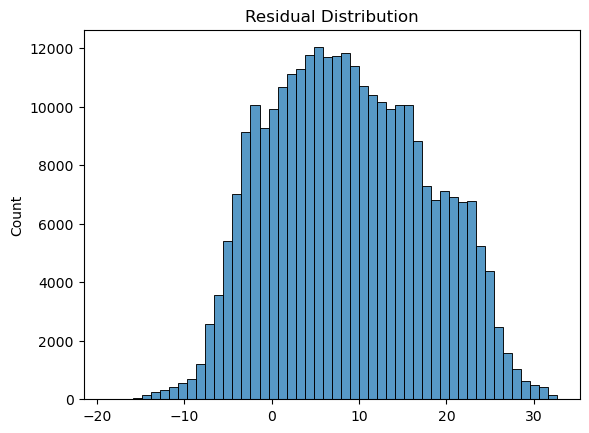

Residual vs. base pred correlation: 0.1801649507479534


In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

# 残差分布
sns.histplot(residual.flatten(), bins=50)
plt.title("Residual Distribution")
plt.show()

# 残差和基线预测的相关性
corr = np.corrcoef(residual.flatten(), oof_preds.flatten())[0,1]
print("Residual vs. base pred correlation:", corr)


In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
from python_scripts.pretrain_model import PretrainedEncoderRegressor
# ---------------- Settings ----------------
trained_oof_model_folder = 'output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/'
n_folds    = len([d for d in os.listdir(trained_oof_model_folder) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35
BATCH_SIZE = 64
start_fold = 0

tile_dim = 128
center_dim = 128
neighbor_dim = 128
fusion_dim = tile_dim + center_dim + neighbor_dim

pretrained_ae_name = 'AE_Center_noaug'
pretrained_ae_path = f"AE_model/128/{pretrained_ae_name}/best.pt"
ae_type = 'center'

# Ground truth label (全 dataset)
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.007522970004049377,
    n_estimators=12000,
    max_depth=11,
    num_leaves=20,
    colsample_bytree=0.7619407413363416,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=20,
    reg_alpha=0.7480401395491829,
    reg_lambda=0.2589860348178542,
    verbosity=-1
    )

slide_idx = np.array(grouped_data['slide_idx'])   # shape (N,)


for fold_id, (tr_idx, va_idx) in enumerate(
    logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue

    print(f"\n🚀 Starting fold {fold_id}...")
    ckpt_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")

    # === Load model and predict OOF ===
    net = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net = net.to(device).eval()

    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds, latents = [], []
    with torch.no_grad():
        for batch in val_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            center = subtiles[:, 4].contiguous()

            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())

    preds = torch.cat(preds, dim=0).numpy()
    latents = torch.cat(latents, dim=0).numpy()

    # === AE model reconstruction loss ===
    recon_model = PretrainedEncoderRegressor(
        ae_checkpoint=pretrained_ae_path,
        ae_type=ae_type,
        tile_dim=tile_dim,
        center_dim=center_dim,
        neighbor_dim=neighbor_dim,
        output_dim=C,
        mode='reconstruction'
    ).to(device)

    meta = generate_meta_features(
        dataset = val_ds,
        oof_preds = preds,
        image_latents = latents,
        model_for_recon = recon_model,
        device = device,
        ae_type = ae_type,
        use_clusters="both"
    )
    
    y_val = y_true[va_idx]   # shape = (len(va_idx), 35)

    # 2) 再對這個 fold 的 meta 做 train/val 切分
    X_train_tab, X_val_tab, y_train_tab, y_val_tab = train_test_split(
        meta, y_val, test_size=0.2, random_state=42
    )

    # 3) train MultiOutputRegressor with early stopping
    meta_model = MultiOutputRegressor(lgb_base)
    meta_model.estimators_ = []

    for i in range(y_train_tab.shape[1]):
        print(f"[fold {fold_id}] training target {i} on meta features …")
        model = lgb.LGBMRegressor(**lgb_base.get_params())
        model.fit(
            X_train_tab, y_train_tab[:, i],
            eval_set=[(X_val_tab, y_val_tab[:, i])],
            callbacks=[
                early_stopping(stopping_rounds=200),
                log_evaluation(period=100)
            ]
        )
        meta_model.estimators_.append(model)

    # 4) 存下這個 fold 的 meta model
    save_path = os.path.join(trained_oof_model_folder, f"meta_model_fold{fold_id}.pkl")
    joblib.dump(meta_model, save_path)
    print(f"✅ Saved fold {fold_id} meta‐model → {save_path}")



🚀 Starting fold 0...


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_35616/4165331370.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, ma

✅ Generated meta-features with shape: (2197, 307)
[fold 0] training target 0 on meta features …
Training until validation scores don't improve for 200 rounds


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/lightgbm/basic.py:743: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


[100]	valid_0's rmse: 6.4752
[200]	valid_0's rmse: 6.28582
[300]	valid_0's rmse: 6.20383
[400]	valid_0's rmse: 6.16166


KeyboardInterrupt: 

In [82]:
import torch
from python_scripts.import_data import load_node_feature_data


image_keys = [ 'tile', 'subtiles']

model = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)

# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



/Users/deweywang/Desktop/GitHub/HEVisum/python_scripts/import_data.py:280: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  raw = torch.load(pt_path, map_location="cpu")


⚠️ 從 '<class 'list'>' 推斷樣本數量: 2088
Model forward signature: (tile, subtiles)


In [ ]:
# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)

all_final = []

for fold_id in range(n_folds):
    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue
    ckpt_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_preds = []
    test_latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            center = subtiles[:, 4].contiguous()

            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
            output = net.decoder(fuse)

            test_preds.append(output.cpu())
            test_latents.append(fuse.cpu())

    test_preds = torch.cat(test_preds, dim=0).numpy()
    test_latents = torch.cat(test_latents, dim=0).numpy()
# === AE model reconstruction loss ===
    recon_model = PretrainedEncoderRegressor(
        ae_checkpoint=pretrained_ae_path,
        ae_type=ae_type,
        tile_dim=tile_dim,
        center_dim=center_dim,
        neighbor_dim=neighbor_dim,
        output_dim=C,
        mode='reconstruction'
    ).to(device)

    meta, name = generate_meta_features(
        dataset = test_dataset,
        oof_preds = test_preds,
        latents = test_latents,
        model_for_recon = recon_model,
        device = device,
        ae_type = ae_type,
    )
    # ** 用训练时同一个 scaler 来标准化 **  
    meta_scaled = scaler.transform(meta)  # (n_test, n_meta_feats)
    # 1) 直接載入整個 MultiOutputRegressor
    meta_model_path =  os.path.join(trained_oof_model_folder, "meta_model.pkl")
    meta_model = joblib.load(meta_model_path)
    # 用 meta_model 预测 residual  
    pred = meta_model.predict(meta_scaled)  #  (n_test, C)


    all_final.append(pred)


final_preds = np.mean(all_final, axis=0)  # (n_test, C)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(trained_oof_model_folder, 'submission_stacked.csv'), index=False)
print(f"✅ Saved stacked submission in {trained_oof_model_folder}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_3581/3306017216.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, map

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

ae-recon-loss -> cols:    1, names:    1 OK
trained-latents -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
sobel-tile   -> cols:   40, names:   40 OK
hsv-tile     -> cols:  120, names:  120 OK
he-tile      -> cols:   80, names:   80 OK
oof          -> cols:   35, names:   35 OK
adj          -> cols:   34, names:   34 OK
last         -> cols:  136, names:  136 OK
mad          -> cols:    1, names:    1 OK
skewness     -> cols:    2, names:    2 OK
autocorr     -> cols:    5, names:    5 OK
diff2        -> cols:   33, names:   33 OK
diff3        -> cols:   32, names:   32 OK
✅ Generated meta-features with shape: (2088, 1222)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

✅ Saved stacked submission in output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/


: 

In [105]:
# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)


for fold_id in range(n_folds):
    if fold_id > start_fold:
        print(f"⏭️ Skipping fold {fold_id}")
        continue
    ckpt_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}", "best_model.pt")
    net = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_preds = []
    test_latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)
            center = subtiles[:, 4].contiguous()

            f_c = net.encoder_center(center)
            f_n = net.encoder_subtile(subtiles)
            f_t = net.encoder_tile(tiles)
            fuse = torch.cat([f_c, f_n, f_t], dim=1).contiguous()
            output = net.decoder(fuse)

            test_preds.append(output.cpu())
            test_latents.append(fuse.cpu())


    test_preds = torch.cat(test_preds, dim=0).numpy()
    test_latents = torch.cat(test_latents, dim=0).numpy()
# === AE model reconstruction loss ===
    recon_model = PretrainedEncoderRegressor(
        ae_checkpoint=pretrained_ae_path,
        ae_type=ae_type,
        tile_dim=tile_dim,
        center_dim=center_dim,
        neighbor_dim=neighbor_dim,
        output_dim=C,
        mode='reconstruction'
    ).to(device)

    meta, name = generate_meta_features(
        dataset = test_dataset,
        oof_preds = test_preds,
        model_for_recon = recon_model,
        device = device,
        ae_type = ae_type,
    )
    # meta, name = groupwise_reduce(
    #     features=test_meta_initial,
    #     names=test_name_initial,
    # )
        
    # 1) 直接載入整個 MultiOutputRegressor
    meta_model_path = os.path.join(trained_oof_model_folder, f"fold{fold_id}","meta_model.pkl")
    meta_model = joblib.load(meta_model_path)

    # 2) 用剛剛算出的 meta features 做預測
    resid_pred = meta_model.predict(meta)
    final_preds = test_preds + resid_pred



# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(trained_oof_model_folder, 'submission_stacked.csv'), index=False)
print(f"✅ Saved stacked submission in {trained_oof_model_folder}")


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_3581/2907721651.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(ckpt_path, map

ae-recon-loss -> cols:    1, names:    1 OK
ae           -> cols:  384, names:  384 OK
subtile4     -> cols:   12, names:   12 OK
exsubtiles   -> cols:   12, names:   12 OK
tile         -> cols:   12, names:   12 OK
contrast     -> cols:    3, names:    3 OK
wavelet-tile -> cols:  280, names:  280 OK
oof          -> cols:   35, names:   35 OK
mad          -> cols:    1, names:    1 OK
✅ Generated meta-features with shape: (2088, 740)


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

⏭️ Skipping fold 1
⏭️ Skipping fold 2
⏭️ Skipping fold 3
⏭️ Skipping fold 4
⏭️ Skipping fold 5
✅ Saved stacked submission in output_folder/rank-spot/realign/no_pretrain/3_encoder/filtered_directly_rank/k-fold/realign_all/Macenko_masked/


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [113]:
import numpy as np
import pandas as pd

# 1) 计算平均 feature_importances
importances = np.vstack([
    est.feature_importances_ 
    for est in meta_model.estimators_
]).mean(axis=0)

# 2) 构造 DataFrame 并排序
df_imp = pd.DataFrame({
    "feature": name,
    "importance": importances
})

# 2) 提取“类别”标签 —— 这里我们以第一个下划线前的字符串当作类别
df_imp['category'] = df_imp['feature'].apply(lambda x: x.split('_')[0])

# 3) 按类别聚合（求和或求平均都可以，下面示例用求和）
cat_imp = df_imp.groupby('category')['importance'] \
            .mean() \
            .sort_values(ascending=False)

print(cat_imp)


# 方法 A：临时设置最大行数，打印时不截断
pd.set_option('display.max_rows', df_imp.shape[0])
print(df_imp)
# 如果代码运行在脚本里，记得在打印完后恢复默认：
pd.reset_option('display.max_rows')

# 方法 B：直接 to_string()
print(df_imp.to_string(index=False))


category
sobel-tile         223.985714
sobel-subtile      204.554762
wavelet-subtile    200.403968
wavelet            194.213810
hsv-tile           178.371429
ae                 142.711310
he-tile            130.703571
oof                118.499592
hsv-subtile        116.662169
he-subtile         110.588889
ae-recon-loss       83.028571
exsubtiles          81.842857
tile                79.740476
subtile4            79.554762
wavelet-tile        71.435714
trained-latents     65.637277
contrast            58.733333
Name: importance, dtype: float64
                                  feature  importance         category
0                    ae-recon-loss_center   83.028571    ae-recon-loss
1                                 ae_emb0   59.771429               ae
2                                 ae_emb1   75.057143               ae
3                                 ae_emb2  106.942857               ae
4                                 ae_emb3   69.057143               ae
5                     

In [ ]:

# # Base model
# lgb_base = lgb.LGBMRegressor(
#     objective='l2',
#     metric='rmse',
#     n_estimators=12000,
#     max_depth=15,
#     learning_rate=0.008,
#     num_leaves=32,
#     colsample_bytree=0.25
# )

lgb_base = lgb.LGBMRegressor(
    objective='l2',
    metric='rmse',
    learning_rate=0.007522970004049377,
    n_estimators=12000,
    max_depth=11,
    num_leaves=194,
    colsample_bytree=0.7619407413363416,
    subsample=0.8,
    subsample_freq=1,
    min_data_in_leaf=20,
    reg_alpha=0.7480401395491829,
    reg_lambda=0.2589860348178542,
    verbosity=-1
)
# 將每個 target 分別 early stopping
meta_model = MultiOutputRegressor(lgb_base)

print("Training LightGBM on OOF meta-features with early stopping...")
meta_model.estimators_ = []

for i in range(y_train.shape[1]):
    print(f"Training target {i}...")
    model  = lgb.LGBMRegressor(
        objective='l2',
        metric='rmse',
        learning_rate=0.007522970004049377,
        n_estimators=12000,
        max_depth=11,
        num_leaves=194,
        colsample_bytree=0.7619407413363416,
        subsample=0.8,
        subsample_freq=1,
        min_data_in_leaf=20,
        reg_alpha=0.7480401395491829,
        reg_lambda=0.2589860348178542,
        verbosity=-1
    )

    model.fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    meta_model.estimators_.append(model)

# 保存模型
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))


# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_preds = []
test_latents = []

for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )

    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            out = net.decoder(fuse)

            preds.append(out.cpu())
            latents.append(fuse.cpu())  # image embedding (128D)

    test_preds.append(torch.cat(preds, dim=0).numpy())      # shape: (n_test, 35)
    test_latents.append(torch.cat(latents, dim=0).numpy())  # shape: (n_test, 128)

# === Stack + Average ===
test_preds = np.mean(np.stack(test_preds, axis=0), axis=0)      # (n_test, 35)
test_latents = np.mean(np.stack(test_latents, axis=0), axis=0)  # (n_test, 128)

with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    df = pd.DataFrame(spot_array)

xy = df[["x", "y"]].to_numpy()  # shape: (n_test, 2)

# 合併為最終 test meta features
test_meta = np.concatenate([test_preds, xy, test_latents], axis=1)  # shape: (n_test, 35+2+128)



final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print(f"✅ Saved stacked submission in {save_root}")


In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict
from lightgbm import early_stopping, log_evaluation
import h5py
import pandas as pd
# ---------------- Settings ----------------
save_root  = save_folder  # your save_folder path
n_folds    = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_samples  = len(full_dataset)
C          = 35  # num cell types
start_fold = 0
BATCH_SIZE = 64
# If optimizing Spearman, convert labels to ranks

# --- 1) Prepare OOF meta-features ---
# Initialize matrix for OOF predictions
n_samples = len(full_dataset)
oof_preds = np.zeros((n_samples, C), dtype=np.float32)
# True labels (raw or rank)
# importDataset returns a dict-like sample, so label is under key 'label'
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true

# Build CV splitter (must match first stage splits)
logo = LeaveOneGroupOut()
image_latents = np.zeros((n_samples, 128), dtype=np.float32)

# Loop over folds, load best model, predict on validation indices
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):
    # Load model
    # if fold_id > start_fold:
    #     print(f"⏭️ Skipping fold {fold_id}")
    #     continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    print(f"Loading model from {ckpt_path}...")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)    # Alternatively, if your model requires specific args, replace with:
    # net = VisionMLP_MultiTask(tile_dim=64, subtile_dim=64, output_dim=35).to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.to(device).eval()
    
    # Predict on validation set
    val_ds = Subset(full_dataset, va_idx)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    preds = []
    latents = []

    with torch.no_grad():
        for batch in val_loader:
            tiles    = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            output = net.decoder(fuse)

            preds.append(output.cpu())
            latents.append(fuse.cpu())  # ⬅️ 收集 latent vector

    preds = torch.cat(preds, dim=0).numpy()    # (n_val, 35)
    latents = torch.cat(latents, dim=0).numpy()  # (n_val, 128)

    oof_preds[va_idx] = preds
    image_latents[va_idx] = latents

    print(f"Fold {fold_id}: OOF preds shape {preds.shape}, Latent shape: {latents.shape}")


    
with h5py.File("dataset/realign/filtered_dataset.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        spot_array = np.array(train_spots[slide_name])
        df = pd.DataFrame(spot_array)
        df["slide_name"] = slide_name
        train_spot_tables[slide_name] = df
        print(f"✅ 已讀取 slide: {slide_name}")

# -----------------------------------------------------
# Step 2: 合併所有 slide 的資料
# -----------------------------------------------------
all_train_spots_df = pd.concat(train_spot_tables.values(), ignore_index=True)
# 提取 x, y
xy = all_train_spots_df[["x", "y"]].to_numpy()  # shape: (8348, 2)

# 合併成新的 meta feature
meta_features = np.concatenate([oof_preds, xy, image_latents], axis=1)
# --- 2) Train LightGBM meta-model ---
# Choose objective: regression on rank (for Spearman) or raw (for MSE)
# 將 meta features 拆成訓練集與 early stopping 用的驗證集
X_train, X_val, y_train, y_val = train_test_split(meta_features, y_meta, test_size=0.2, random_state=42)
print("Meta feature shape:", X_train.shape)
print("Feature std (min/max):", np.min(np.std(X_train, axis=0)), np.max(np.std(X_train, axis=0)))


# # Base model
# lgb_base = lgb.LGBMRegressor(
#     objective='l2',
#     metric='rmse',
#     n_estimators=12000,
#     max_depth=15,
#     learning_rate=0.008,
#     num_leaves=32,
#     colsample_bytree=0.25
# )
import optuna
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

# Define Optuna objective function
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'device': 'gpu',                # ✅ GPU 支援
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'learning_rate': trial.suggest_float("learning_rate", 0.005, 0.1),
        'max_depth': trial.suggest_int("max_depth", 4, 15),
        'num_leaves': trial.suggest_int("num_leaves", 32, 256),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 20, 100),
        'colsample_bytree': trial.suggest_float("colsample_bytree", 0.6, 1.0),
        'reg_alpha': trial.suggest_float("reg_alpha", 0, 1),
        'reg_lambda': trial.suggest_float("reg_lambda", 0, 1),
        'n_estimators': 12000
    }

    model = lgb.LGBMRegressor(**params)
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train, y_train)

    y_pred = multi_model.predict(X_val)
    rmse = np.mean([
        np.sqrt(mean_squared_error(y_val[:, i], y_pred[:, i]))
        for i in range(y_val.shape[1])
    ])


    return rmse

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Use best params to train final models
best_params = study.best_trial.params
best_params['objective'] = 'l2'
best_params['metric'] = 'rmse'
best_params['verbosity'] = -1

# Train final models with best parameters
meta_model = MultiOutputRegressor(lgb.LGBMRegressor(**best_params))
meta_model.estimators_ = []

print("Training LightGBM on OOF meta-features with best Optuna params...")
for i in range(y_train.shape[1]):
    print(f"Training target {i}...")
    model = lgb.LGBMRegressor(**best_params)

    model.fit(
        X_train,
        y_train[:, i],
        eval_set=[(X_val, y_val[:, i])],
        callbacks=[
            early_stopping(stopping_rounds=200),
            log_evaluation(period=100)
        ]
    )

    meta_model.estimators_.append(model)

# Save model
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))
# 保存模型


# --- 3) Prepare test meta-features ---
n_test = len(test_dataset)
test_preds = []
test_latents = []

for fold_id in range(n_folds):
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    net.decoder = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
    )

    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = []
    latents = []

    with torch.no_grad():
        for batch in test_loader:
            tiles = batch['tile'].to(device)
            subtiles = batch['subtiles'].to(device)

            center = subtiles[:, 4].contiguous()
            f_c = net.enc_center(center)
            f_n = net.enc_neigh(subtiles)
            fuse = torch.cat([f_c, f_n], dim=1)

            out = net.decoder(fuse)

            preds.append(out.cpu())
            latents.append(fuse.cpu())  # image embedding (128D)

    test_preds.append(torch.cat(preds, dim=0).numpy())      # shape: (n_test, 35)
    test_latents.append(torch.cat(latents, dim=0).numpy())  # shape: (n_test, 128)

# === Stack + Average ===
test_preds = np.mean(np.stack(test_preds, axis=0), axis=0)      # (n_test, 35)
test_latents = np.mean(np.stack(test_latents, axis=0), axis=0)  # (n_test, 128)

with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    spot_array = np.array(test_spots['S_7'])
    df = pd.DataFrame(spot_array)

xy = df[["x", "y"]].to_numpy()  # shape: (n_test, 2)

# 合併為最終 test meta features
test_meta = np.concatenate([test_preds, xy, test_latents], axis=1)  # shape: (n_test, 35+2+128)



final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))
sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


In [ ]:
import os
import numpy as np
import joblib
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from scipy.stats import rankdata
from python_scripts.import_data import importDataset
from python_scripts.operate_model import predict

# --- 配置: 只用哪些 fold 的结果来训练/预测 meta-model ---
meta_folds = [0]  # 例如只用 fold0, fold2, fold4

# 1) 准备 full_dataset, slide_idx, test_dataset 等
full_dataset = importDataset(
    grouped_data, model,
    image_keys=['tile','subtiles'],
    transform=lambda x: x
)
n_samples = len(full_dataset)
C = 35  # 类别数

# 2) 预留 oof_preds 和 fold_ids
oof_preds    = np.zeros((n_samples, C), dtype=np.float32)
oof_fold_ids = np.full(n_samples, -1, dtype=int)

# 真标签
y_true = np.vstack([ full_dataset[i]['label'].cpu().numpy() for i in range(n_samples) ])
y_meta = y_true.copy()  # 不做 rank 时直接用 raw

# 3) 生成 OOF 预测并记录 fold id
logo = LeaveOneGroupOut()
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

for fold_id, (tr_idx, va_idx) in enumerate(
        logo.split(X=np.zeros(n_samples), y=None, groups=slide_idx)):

    # 如果当前 fold 不在我们想要的 meta_folds 列表里，就跳过
    if fold_id not in meta_folds:
        print(f"⏭️ Skipping OOF for fold {fold_id}")
        continue

    print(f"\n>>> Generating OOF for fold {fold_id}")
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    val_loader = DataLoader(Subset(full_dataset, va_idx), batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, val_loader, device)  # (n_val, C)

    oof_preds[va_idx]    = preds
    oof_fold_ids[va_idx] = fold_id

    print(f"  → Fold {fold_id} OOF preds shape: {preds.shape}")
# 4) 只选取 meta_folds 的行来训练 meta-model
mask = np.isin(oof_fold_ids, meta_folds)
X_meta = oof_preds[mask]
y_meta_sub = y_meta[mask]

print(f"\nTraining meta-model on folds {meta_folds}:")
print(f"  使用样本数：{X_meta.shape[0]} / {n_samples}")

lgb_base = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.001,
    n_estimators=1000,
    num_leaves=31,
    subsample=0.7,
    colsample_bytree=0.7,
    n_jobs=-1,
    force_col_wise=True
)
meta_model = MultiOutputRegressor(lgb_base)
meta_model.fit(X_meta, y_meta_sub)
joblib.dump(meta_model, os.path.join(save_root, 'meta_model.pkl'))

# 5) 准备 test_meta，只平均 meta_folds 中的预测
n_folds = len([d for d in os.listdir(save_root) if d.startswith('fold')])
n_test  = len(test_dataset)
test_meta = np.zeros((n_test, C), dtype=np.float32)

for fold_id in range(n_folds):
    if fold_id not in meta_folds:
        continue
    ckpt_path = os.path.join(save_root, f"fold{fold_id}", "best_model.pt")
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = True
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt_path, map_location=device))
    net.eval()

    loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    preds = predict(net, loader, device)
    test_meta += preds

# 平均时除以参与的 folds 数目
test_meta /= len(meta_folds)

# 6) 用 meta-model 做最终预测
final_preds = meta_model.predict(test_meta)

# --- Save submission ---
import h5py
import pandas as pd

with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spot_ids = pd.DataFrame(np.array(f["spots/Test"]["S_7"]))

sub = pd.DataFrame(final_preds, columns=[f"C{i+1}" for i in range(C)])
sub.insert(0, 'ID', test_spot_ids.index)
sub.to_csv(os.path.join(save_root, 'submission_stacked.csv'), index=False)
print("✅ Saved stacked submission.")


# Predict

In [20]:
import torch
import inspect
from python_scripts.operate_model import get_model_inputs
from python_scripts.import_data import load_node_feature_data


image_keys = [ 'tile', 'subtiles']

model = VisionMLP_MultiTask(tile_dim=tile_dim, subtile_dim=center_dim, output_dim=C)

# 用法示例
from python_scripts.import_data import importDataset
# 假设你的 model 已经定义好并实例化为 `model`
test_dataset = load_node_feature_data("dataset/spot-rank/filtered_directly_rank/masked/test/Macenko/test_dataset.pt", model)
test_dataset = importDataset(
        data_dict=test_dataset,
        model=model,
        image_keys=image_keys,
        transform=lambda x: x,  # identity transform
        print_sig=True
    )



⚠️ 從 '<class 'list'>' 推斷樣本數量: 2088
Model forward signature: (tile, subtiles)


In [ ]:

test_dataset.check_item(1000, 10)


In [21]:
from torch.utils.data import DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import glob
import torch
import numpy as np
import pandas as pd
import os
import h5py
from torch.utils.data import DataLoader

# 讀 test spot index
with h5py.File("./dataset/elucidata_ai_challenge_data.h5","r") as f:
    test_spots     = f["spots/Test"]
    test_spot_table= pd.DataFrame(np.array(test_spots['S_7']))

fold_ckpts = sorted(glob.glob(os.path.join(save_folder, "fold*", "best_model.pt")))
models = []
for ckpt in fold_ckpts:
    net = PretrainedEncoderRegressor(
        ae_checkpoint=checkpoint_path,
        ae_type="all",
        center_dim=64, neighbor_dim=64, hidden_dim=128,
        tile_size=26, output_dim=35,
        freeze_encoder = False
    )

    # 2) monkey‐patch 一个新的 head
    net.decoder  = nn.Sequential(
        nn.Linear(64+64, 256),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(256, 128),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(128, 64),
        nn.SiLU(),
        nn.Dropout(0.1),
        nn.Linear(64, 35)
        
    )
    net = net.to(device)
    net.load_state_dict(torch.load(ckpt, map_location="cpu"))
    net.to(device).eval()
    models.append(net)

all_fold_preds = []
for fold_id, net in enumerate(models):
    # 推論
    with torch.no_grad():
        preds = predict(net, test_loader, device)  # (N_test,35) numpy array

    # 1) 存每一折的原始預測
    df_fold = pd.DataFrame(preds, columns=[f"C{i+1}" for i in range(preds.shape[1])])
    df_fold.insert(0, "ID", test_spot_table.index)
    path_fold = os.path.join(save_folder, f"submission_fold{fold_id}.csv")
    df_fold.to_csv(path_fold, index=False)
    print(f"✅ Saved fold {fold_id} predictions to {path_fold}")

    all_fold_preds.append(preds)

# 2) 做 rank‐average ensemble
all_fold_preds = np.stack(all_fold_preds, axis=0)       # (K, N_test, 35)
ranks          = all_fold_preds.argsort(axis=2).argsort(axis=2).astype(float)
mean_rank      = ranks.mean(axis=0)                    # (N_test,35)

# 3) 存 final ensemble
df_ens = pd.DataFrame(mean_rank, columns=[f"C{i+1}" for i in range(mean_rank.shape[1])])
df_ens.insert(0, "ID", test_spot_table.index)
path_ens = os.path.join(save_folder, "submission_rank_ensemble.csv")
df_ens.to_csv(path_ens, index=False)
print(f"✅ Saved rank‐ensemble submission to {path_ens}")
